In [93]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer



In [102]:
datasets = {
    'us_crime': "https://archive.ics.uci.edu/static/public/183/data.csv",
    'letter_img': "https://archive.ics.uci.edu/static/public/59/data.csv",
    'mammography': "https://archive.ics.uci.edu/static/public/161/data.csv"
}

data_dict = {}
for name, url in datasets.items():
    data = pd.read_csv(url, header=None)

    if name == 'us_crime':
        data = data.drop(columns=[3])
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].astype(float).apply(lambda x: 1 if x > 0.65 else 0).astype(int)  # Target is the last column
    elif name == 'letter_img':
        X = data.iloc[1:, 1:]  # Features start from the second column
        y = data.iloc[1:, 0].apply(lambda x: 1 if x == 'Z' else 0).astype(int)   # Target is the first column
    elif name == 'mammography':
        X = data.iloc[1:, :-1]
        y = data.iloc[1:, -1].astype(int)  # Target is the last column
    data_dict[name] = (X, y)


In [96]:
def calculate_f1_scores(X, y):
    f1_scores = []
    for i in range(X.shape[1]):
        X_feature = X.iloc[:, i].values.reshape(-1, 1)

        # Convert '?' to NaN and then impute missing values
        X_feature = np.where(X_feature == '?', np.nan, X_feature)
        imputer = SimpleImputer(strategy='most_frequent') # Or another suitable strategy
        X_feature = imputer.fit_transform(X_feature)

        X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.25, random_state=42)


        clf = DecisionTreeClassifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        average = 'binary'
        f1 = f1_score(y_test, y_pred, average= average)
        f1_scores.append(f1)

    return f1_scores


In [97]:
def evaluate_svm_with_selected_features(X, y, feature_ranking, fractions):
    results = {'fraction': [], 'f1_score': [], 'precision': [], 'recall': []}

    for fraction in fractions:
        num_features = max(1, int(fraction * X.shape[1])) # ensure that at least one feature is selected.
        selected_features = feature_ranking[:num_features]
        X_selected = X.iloc[:, selected_features]

        # Convert '?' to NaN and then impute missing values
        X_selected = np.where(X_selected == '?', np.nan, X_selected)
        imputer = SimpleImputer(strategy='mean') #most_frequent
        X_selected = imputer.fit_transform(X_selected)

        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        svm = SVC(kernel='rbf', class_weight= 'balanced')
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        average = 'binary'
        f1 = f1_score(y_test, y_pred, average= average)
        precision = precision_score(y_test, y_pred, average= average)
        recall = recall_score(y_test, y_pred, average= average)

        results['fraction'].append(fraction)
        results['f1_score'].append(f1)
        results['precision'].append(precision)
        results['recall'].append(recall)

    return results


In [74]:
feature_ranking
# f1_scores

[0.798076923076923,
 0.798076923076923,
 0.798076923076923,
 0.7981220657276995,
 0.7981220657276995,
 0.8389830508474576,
 0.8389830508474576,
 0.8189655172413793,
 0.8189655172413793,
 0.8189655172413793]

Evaluating dataset: us_crime
  X shape: (1994, 126)
  y shape: (1994,)
  Ratio: 12:1


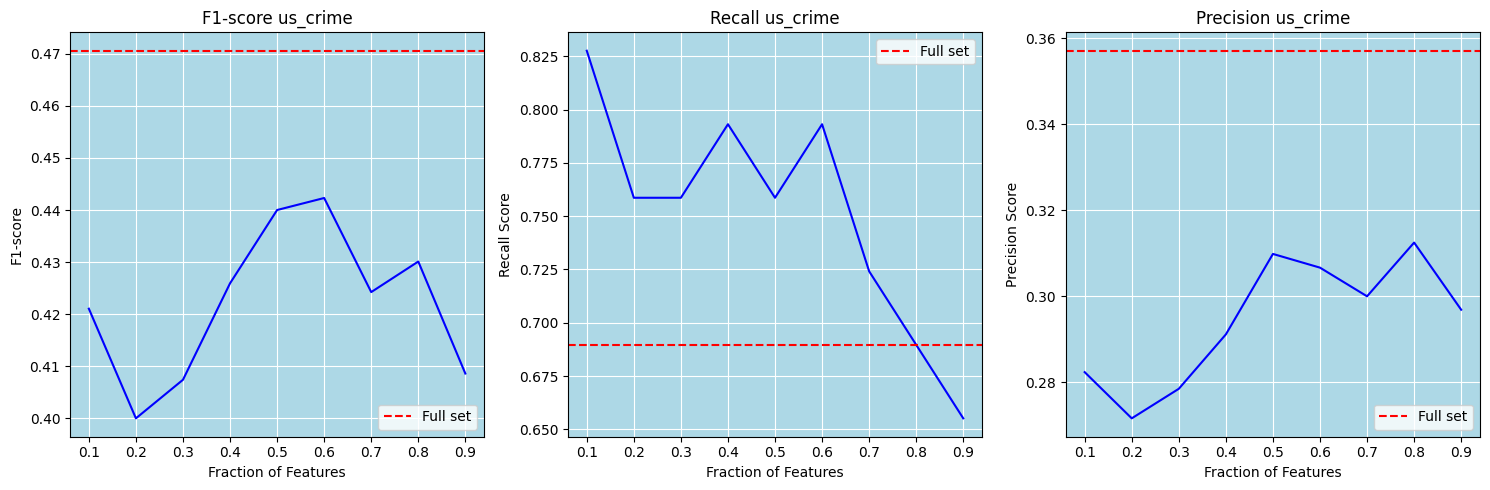

The best fraction of features in this problem based on the F1-score is 1.0
********************
Evaluating dataset: letter_img
  X shape: (20000, 16)
  y shape: (20000,)
  Ratio: 26:1


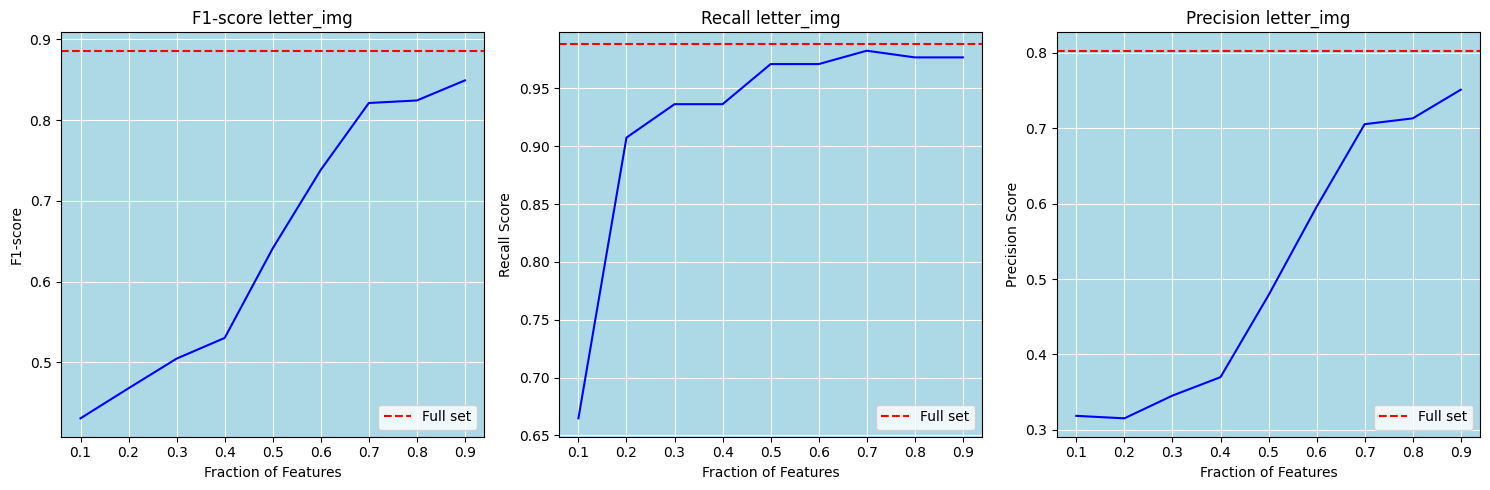

The best fraction of features in this problem based on the F1-score is 1.0
********************
Evaluating dataset: mammography
  X shape: (961, 5)
  y shape: (961,)
  Ratio: 1:1


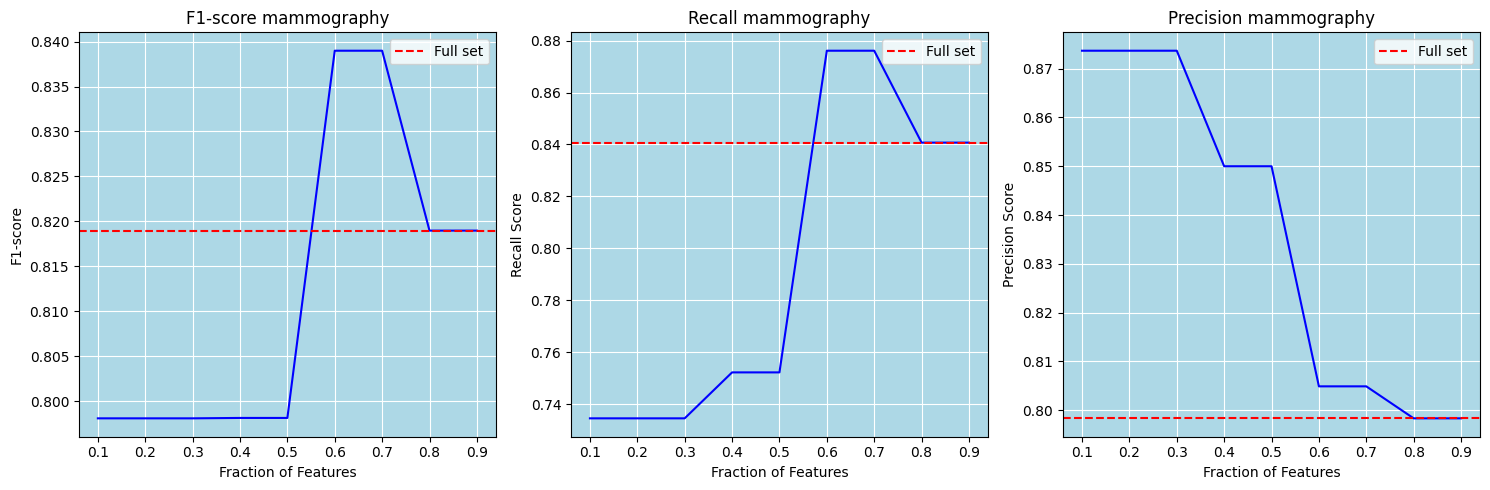

The best fraction of features in this problem based on the F1-score is 0.6
********************


In [118]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for name, (X, y) in data_dict.items():
    print(f"Evaluating dataset: {name}")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")
    unique, counts = np.unique(y, return_counts=True)
    ratio = int(counts[np.argmax(counts)] / counts[np.argmin(counts)])
    print(f"  Ratio: {ratio}:1")
    # print("\n")

    f1_scores = calculate_f1_scores(X, y)

    # Rank features based on F1-scores
    feature_ranking = np.argsort(f1_scores)[::-1]

    # Evaluate SVM classifier with selected features
    results = evaluate_svm_with_selected_features(X, y, feature_ranking, fractions)

    # Extract the scores for plotting
    f1_scores = results['f1_score']
    recall_scores = results['recall']
    precision_scores = results['precision']

    # Plot the results
    plt.figure(figsize=(15, 5))

    # Plot F1-score
    plt.subplot(1, 3, 1)
    plt.plot(fractions[: -1], f1_scores[: -1], color= "blue")
    plt.axhline(y= f1_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'F1-score {name}')
    plt.xlabel('Fraction of Features')
    plt.ylabel('F1-score')
    plt.grid(True, color='white')
    plt.gca().set_facecolor('lightblue')
    plt.grid(True)
    plt.legend()

    # Plot Recall score
    plt.subplot(1, 3, 2)
    plt.plot(fractions[: -1], recall_scores[: -1], color= "blue")
    plt.axhline(y= recall_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'Recall {name}')
    plt.xlabel('Fraction of Features')
    plt.ylabel('Recall Score')
    plt.grid(True, color='white')
    plt.gca().set_facecolor('lightblue')
    plt.grid(True)
    plt.legend()

    # Plot Precision score
    plt.subplot(1, 3, 3)
    plt.plot(fractions[: -1], precision_scores[: -1], color= "blue")
    plt.axhline(y= precision_scores[-1], xmin= 0, xmax= 1.0+ 0.05,
            label='Full set', color="red", linestyle='--')

    plt.title(f'Precision {name}')
    plt.xlabel('Fraction of Features')
    plt.ylabel('Precision Score')
    plt.grid(True, color='white')  # White grid lines
    plt.gca().set_facecolor('lightblue')  # Light blue background
    plt.grid(True)

    plt.tight_layout()
    plt.legend()
    plt.show()

    print("The best fraction of features in this problem based on the F1-score is", fractions[f1_scores.index(max(f1_scores))])
    print(20* '*', '\n')

# **This shows that we do not necessarily need to use all the features for having a good ML model.**

In [ ]:
# prompt: I want Summary metrics tables comparing the performance using the top 0.1 fraction of features vs the full feature set in the plots titled f1-score, recall and precision

for name, (X, y) in data_dict.items():
    print(f"Evaluating dataset: {name}")

    f1_scores = calculate_f1_scores(X, y)

    # Rank features based on F1-scores
    feature_ranking = np.argsort(f1_scores)[::-1]

    # Evaluate SVM classifier with selected features
    fractions = [0.1, 1.0]  # Evaluate for 0.1 and 1.0 (full set) fractions
    results = evaluate_svm_with_selected_features(X, y, feature_ranking, fractions)

    # Create summary table
    summary_df = pd.DataFrame({
        'Fraction of Features': results['fraction'],
        'F1-score': results['f1_score'],
        'Precision': results['precision'],
        'Recall': results['recall']
    })

    print(summary_df)
    print(20* '*', '\n')
